<a href="https://colab.research.google.com/github/RaihanAzharRafi/Machine-Learning/blob/main/WEEK%2013/Week_13_RNN_rnn_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Implementation of Recurrent Neural Networks from Scratch**
### **Nama : Raihan Azhar Rafi**
### **Kelas : TK-42-02**
### **Nim : 1103180166**

Sumber Saya Peroleh Dari : http://www.d2l.ai/chapter_recurrent-neural-networks/rnn-scratch.html

In [1]:
!pip install d2l==0.17.5


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Implementation of Recurrent Neural Networks from Scratch
:label:`sec_rnn_scratch`

In this section we will implement an RNN
from scratch
for a character-level language model,
according to our descriptions
in :numref:`sec_rnn`.
Such a model
will be trained on H. G. Wells' *The Time Machine*.
As before, we start by reading the dataset first, which is introduced in :numref:`sec_language_model`.


In [2]:
%matplotlib inline
import math
import tensorflow as tf
from d2l import tensorflow as d2l

In [3]:
batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

In [4]:
train_random_iter, vocab_random_iter = d2l.load_data_time_machine(
    batch_size, num_steps, use_random_iter=True)

## [**One-Hot Encoding**]

Recall that each token is represented as a numerical index in `train_iter`.
Feeding these indices directly to a neural network might make it hard to
learn.
We often represent each token as a more expressive feature vector.
The easiest representation is called *one-hot encoding*,
which is introduced
in :numref:`subsec_classification-problem`.

In a nutshell, we map each index to a different unit vector: assume that the number of different tokens in the vocabulary is $N$ (`len(vocab)`) and the token indices range from $0$ to $N-1$.
If the index of a token is the integer $i$, then we create a vector of all 0s with a length of $N$ and set the element at position $i$ to 1.
This vector is the one-hot vector of the original token. The one-hot vectors with indices 0 and 2 are shown below.


In [5]:
tf.one_hot(tf.constant([0, 2]), len(vocab))

<tf.Tensor: shape=(2, 28), dtype=float32, numpy=
array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)>

(**The shape of the minibatch**) that we sample each time (**is (batch size, number of time steps).
The `one_hot` function transforms such a minibatch into a three-dimensional tensor with the last dimension equals to the vocabulary size (`len(vocab)`).**)
We often transpose the input so that we will obtain an
output of shape
(number of time steps, batch size, vocabulary size).
This will allow us
to more conveniently
loop through the outermost dimension
for updating hidden states of a minibatch,
time step by time step.


In [6]:
X = tf.reshape(tf.range(10), (2, 5))
tf.one_hot(tf.transpose(X), 28).shape

TensorShape([5, 2, 28])

## Initializing the Model Parameters

Next, we [**initialize the model parameters for
the RNN model**].
The number of hidden units `num_hiddens` is a tunable hyperparameter.
When training language models,
the inputs and outputs are from the same vocabulary.
Hence, they have the same dimension,
which is equal to the vocabulary size.


In [7]:
def get_params(vocab_size, num_hiddens):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return tf.random.normal(shape=shape,stddev=0.01,mean=0,dtype=tf.float32)

    # Hidden layer parameters
    W_xh = tf.Variable(normal((num_inputs, num_hiddens)), dtype=tf.float32)
    W_hh = tf.Variable(normal((num_hiddens, num_hiddens)), dtype=tf.float32)
    b_h = tf.Variable(tf.zeros(num_hiddens), dtype=tf.float32)
    # Output layer parameters
    W_hq = tf.Variable(normal((num_hiddens, num_outputs)), dtype=tf.float32)
    b_q = tf.Variable(tf.zeros(num_outputs), dtype=tf.float32)
    params = [W_xh, W_hh, b_h, W_hq, b_q]
    return params

## RNN Model

To define an RNN model,
we first need [**an `init_rnn_state` function
to return the hidden state at initialization.**]
It returns a tensor filled with 0 and with a shape of (batch size, number of hidden units).
Using tuples makes it easier to handle situations where the hidden state contains multiple variables,
which we will encounter in later sections.


In [8]:
def init_rnn_state(batch_size, num_hiddens):
    return (tf.zeros((batch_size, num_hiddens)), )

[**The following `rnn` function defines how to compute the hidden state and output
at a time step.**]
Note that
the RNN model
loops through the outermost dimension of `inputs`
so that it updates hidden states `H` of a minibatch,
time step by time step.
Besides,
the activation function here uses the $\tanh$ function.
As
described in :numref:`sec_mlp`, the
mean value of the $\tanh$ function is 0, when the elements are uniformly
distributed over the real numbers.


In [9]:
def rnn(inputs, state, params):
    # Here `inputs` shape: (`num_steps`, `batch_size`, `vocab_size`)
    W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []
    # Shape of `X`: (`batch_size`, `vocab_size`)
    for X in inputs:
        X = tf.reshape(X,[-1,W_xh.shape[0]])
        H = tf.tanh(tf.matmul(X, W_xh) + tf.matmul(H, W_hh) + b_h)
        Y = tf.matmul(H, W_hq) + b_q
        outputs.append(Y)
    return tf.concat(outputs, axis=0), (H,)

With all the needed functions being defined,
next we [**create a class to wrap these functions and store parameters**] for an RNN model implemented from scratch.


In [10]:
class RNNModelScratch: #@save
    """A RNN Model implemented from scratch."""
    def __init__(self, vocab_size, num_hiddens,
                 init_state, forward_fn, get_params):
        self.vocab_size, self.num_hiddens = vocab_size, num_hiddens
        self.init_state, self.forward_fn = init_state, forward_fn
        self.trainable_variables = get_params(vocab_size, num_hiddens)

    def __call__(self, X, state):
        X = tf.one_hot(tf.transpose(X), self.vocab_size)
        X = tf.cast(X, tf.float32)
        return self.forward_fn(X, state, self.trainable_variables)

    def begin_state(self, batch_size, *args, **kwargs):
        return self.init_state(batch_size, self.num_hiddens)

Let us [**check whether the outputs have the correct shapes**], e.g., to ensure that the dimensionality of the hidden state remains unchanged.


In [11]:
# defining tensorflow training strategy
device_name = d2l.try_gpu()._device_name
strategy = tf.distribute.OneDeviceStrategy(device_name)

num_hiddens = 512
with strategy.scope():
    net = RNNModelScratch(len(vocab), num_hiddens, init_rnn_state, rnn,
                          get_params)
state = net.begin_state(X.shape[0])
Y, new_state = net(X, state)
Y.shape, len(new_state), new_state[0].shape

(TensorShape([10, 28]), 1, TensorShape([2, 512]))

We can see that the output shape is (number of time steps $\times$ batch size, vocabulary size), while the hidden state shape remains the same, i.e., (batch size, number of hidden units).


## Prediction

Let us [**first define the prediction function
to generate new characters following
the user-provided `prefix`**],
which is a string containing several characters.
When looping through these beginning characters in `prefix`,
we keep passing the hidden state
to the next time step without
generating any output.
This is called the *warm-up* period,
during which the model updates itself
(e.g., update the hidden state)
but does not make predictions.
After the warm-up period,
the hidden state is generally better than
its initialized value at the beginning.
So we generate the predicted characters and emit them.


In [12]:
def predict_ch8(prefix, num_preds, net, vocab):  #@save
    """Generate new characters following the `prefix`."""
    state = net.begin_state(batch_size=1, dtype=tf.float32)
    outputs = [vocab[prefix[0]]]
    get_input = lambda: tf.reshape(tf.constant([outputs[-1]]), (1, 1)).numpy()
    for y in prefix[1:]:  # Warm-up period
        _, state = net(get_input(), state)
        outputs.append(vocab[y])
    for _ in range(num_preds):  # Predict `num_preds` steps
        y, state = net(get_input(), state)
        outputs.append(int(y.numpy().argmax(axis=1).reshape(1)))
    return ''.join([vocab.idx_to_token[i] for i in outputs])

Now we can test the `predict_ch8` function.
We specify the prefix as `time traveller ` and have it generate 10 additional characters.
Given that we have not trained the network,
it will generate nonsensical predictions.


In [13]:
predict_ch8('time traveller ', 10, net, vocab)

'time traveller mhkjtl mhk'

## [**Gradient Clipping**]

For a sequence of length $T$,
we compute the gradients over these $T$ time steps in an iteration, which results in a chain of matrix-products with length  $\mathcal{O}(T)$ during backpropagation.
As mentioned in :numref:`sec_numerical_stability`, it might result in numerical instability, e.g., the gradients may either explode or vanish, when $T$ is large. Therefore, RNN models often need extra help to stabilize the training.

Generally speaking,
when solving an optimization problem,
we take update steps for the model parameter,
say in the vector form
$\mathbf{x}$,
in the direction of the negative gradient $\mathbf{g}$ on a minibatch.
For example,
with $\eta > 0$ as the learning rate,
in one iteration we update
$\mathbf{x}$
as $\mathbf{x} - \eta \mathbf{g}$.
Let us further assume that the objective function $f$
is well behaved, say, *Lipschitz continuous* with constant $L$.
That is to say,
for any $\mathbf{x}$ and $\mathbf{y}$ we have

$$|f(\mathbf{x}) - f(\mathbf{y})| \leq L \|\mathbf{x} - \mathbf{y}\|.$$

In this case we can safely assume that if we update the parameter vector by $\eta \mathbf{g}$, then

$$|f(\mathbf{x}) - f(\mathbf{x} - \eta\mathbf{g})| \leq L \eta\|\mathbf{g}\|,$$

which means that
we will not observe a change by more than $L \eta \|\mathbf{g}\|$. This is both a curse and a blessing.
On the curse side,
it limits the speed of making progress;
whereas on the blessing side,
it limits the extent to which things can go wrong if we move in the wrong direction.

Sometimes the gradients can be quite large and the optimization algorithm may fail to converge. We could address this by reducing the learning rate $\eta$. But what if we only *rarely* get large gradients? In this case such an approach may appear entirely unwarranted. One popular alternative is to clip the gradient $\mathbf{g}$ by projecting them back to a ball of a given radius, say $\theta$ via

(**$$\mathbf{g} \leftarrow \min\left(1, \frac{\theta}{\|\mathbf{g}\|}\right) \mathbf{g}.$$**)

By doing so we know that the gradient norm never exceeds $\theta$ and that the
updated gradient is entirely aligned with the original direction of $\mathbf{g}$.
It also has the desirable side-effect of limiting the influence any given
minibatch (and within it any given sample) can exert on the parameter vector. This
bestows a certain degree of robustness to the model. Gradient clipping provides
a quick fix to the gradient exploding. While it does not entirely solve the problem, it is one of the many techniques to alleviate it.

Below we define a function to clip the gradients of
a model that is implemented from scratch or a model constructed by the high-level APIs.
Also note that we compute the gradient norm over all the model parameters.


In [14]:
def grad_clipping(grads, theta):  #@save
    """Clip the gradient."""
    theta = tf.constant(theta, dtype=tf.float32)
    new_grad = []
    for grad in grads:
        if isinstance(grad, tf.IndexedSlices):
            new_grad.append(tf.convert_to_tensor(grad))
        else:
            new_grad.append(grad)
    norm = tf.math.sqrt(sum((tf.reduce_sum(grad ** 2)).numpy()
                        for grad in new_grad))
    norm = tf.cast(norm, tf.float32)
    if tf.greater(norm, theta):
        for i, grad in enumerate(new_grad):
            new_grad[i] = grad * theta / norm
    else:
        new_grad = new_grad
    return new_grad

## Training

Before training the model,
let us [**define a function to train the model in one epoch**]. It differs from how we train the model of :numref:`sec_softmax_scratch` in three places:

1. Different sampling methods for sequential data (random sampling and sequential partitioning) will result in differences in the initialization of hidden states.
1. We clip the gradients before updating the model parameters. This ensures that the model does not diverge even when gradients blow up at some point during the training process.
1. We use perplexity to evaluate the model. As discussed in :numref:`subsec_perplexity`, this ensures that sequences of different length are comparable.


Specifically,
when sequential partitioning is used, we initialize the hidden state only at the beginning of each epoch.
Since the $i^\mathrm{th}$ subsequence example  in the next minibatch is adjacent to the current $i^\mathrm{th}$ subsequence example,
the hidden state at the end of the current minibatch
will be
used to initialize
the hidden state at the beginning of the next minibatch.
In this way,
historical information of the sequence
stored in the hidden state
might flow over
adjacent subsequences within an epoch.
However, the computation of the hidden state
at any point depends on all the previous minibatches
in the same epoch,
which complicates the gradient computation.
To reduce computational cost,
we detach the gradient before processing any minibatch
so that the gradient computation of the hidden state
is always limited to
the time steps in one minibatch. 

When using the random sampling,
we need to re-initialize the hidden state for each iteration since each example is sampled with a random position.
Same as the `train_epoch_ch3` function in :numref:`sec_softmax_scratch`,
`updater` is a general function
to update the model parameters.
It can be either the `d2l.sgd` function implemented from scratch or the built-in optimization function in
a deep learning framework.


In [15]:
#@save
def train_epoch_ch8(net, train_iter, loss, updater, use_random_iter):
    """Train a model within one epoch (defined in Chapter 8)."""
    state, timer = None, d2l.Timer()
    metric = d2l.Accumulator(2)  # Sum of training loss, no. of tokens
    for X, Y in train_iter:
        if state is None or use_random_iter:
            # Initialize `state` when either it is the first iteration or
            # using random sampling
            state = net.begin_state(batch_size=X.shape[0], dtype=tf.float32)
        with tf.GradientTape(persistent=True) as g:
            y_hat, state = net(X, state)
            y = tf.reshape(tf.transpose(Y), (-1))
            l = loss(y, y_hat)
        params = net.trainable_variables
        grads = g.gradient(l, params)
        grads = grad_clipping(grads, 1)
        updater.apply_gradients(zip(grads, params))

        # Keras loss by default returns the average loss in a batch
        # l_sum = l * float(d2l.size(y)) if isinstance(
        #     loss, tf.keras.losses.Loss) else tf.reduce_sum(l)
        metric.add(l * d2l.size(y), d2l.size(y))
    return math.exp(metric[0] / metric[1]), metric[1] / timer.stop()

[**The training function supports
an RNN model implemented
either from scratch
or using high-level APIs.**]


In [16]:
#@save
def train_ch8(net, train_iter, vocab, lr, num_epochs, strategy,
              use_random_iter=False):
    """Train a model (defined in Chapter 8)."""
    with strategy.scope():
        loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
        updater = tf.keras.optimizers.SGD(lr)
    animator = d2l.Animator(xlabel='epoch', ylabel='perplexity',
                            legend=['train'], xlim=[10, num_epochs])
    predict = lambda prefix: predict_ch8(prefix, 50, net, vocab)
    # Train and predict
    for epoch in range(num_epochs):
        ppl, speed = train_epoch_ch8(net, train_iter, loss, updater,
                                     use_random_iter)
        if (epoch + 1) % 10 == 0:
            print(predict('time traveller'))
            animator.add(epoch + 1, [ppl])
    device = d2l.try_gpu()._device_name
    print(f'perplexity {ppl:.1f}, {speed:.1f} tokens/sec on {str(device)}')
    print(predict('time traveller'))
    print(predict('traveller'))

[**Now we can train the RNN model.**]
Since we only use 10000 tokens in the dataset, the model needs more epochs to converge better.


perplexity 1.0, 15216.3 tokens/sec on /GPU:0
time travelleryou can show black is white by argument said filby
traveller with a slight accession ofcheerfulness really thi


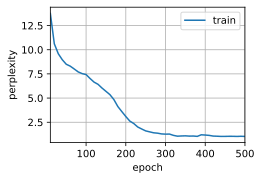

In [17]:
num_epochs, lr = 500, 1
train_ch8(net, train_iter, vocab, lr, num_epochs, strategy)

[**Finally,
let us check the results of using the random sampling method.**]


perplexity 1.4, 15633.0 tokens/sec on /GPU:0
time travellerit s against reason said filbywhat the hasexotee i
travellerit s against reason said filbywhat the hasexotee i


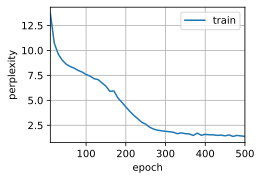

In [18]:
with strategy.scope():
    net = RNNModelScratch(len(vocab), num_hiddens, init_rnn_state, rnn,
                          get_params)
train_ch8(net, train_iter, vocab_random_iter, lr, num_epochs, strategy,
          use_random_iter=True)